# Impact of choice of Hudson Bay boundary concentrations on domain

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import pandas as pd
import xarray as xr

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# model results:
year = 2007
folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year}_20230308/'
folder2 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-Hudson-Bay-{year}_20230308/'

# colors:
c_masked = '#bbbbba'

#### Load files:

In [3]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
ANHA12_lon   = mfile['nav_lon'].values[imin:imax,jmin:jmax]
ANHA12_lat   = mfile['nav_lat'].values[imin:imax,jmin:jmax]
depth_level  = mfile['nav_lev'].values
tmask        = mfile['tmask'].values
tmask_sub    = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]

mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_bathy   = mesh['hdept'].values[0]
e3t          = mesh['e3t_0'].values[0,:,imin:imax,jmin:jmax]
land_mask    = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 
e3t_masked   = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

In [4]:
dissolpb1 = np.zeros((12,50,isize,jsize))
dissolpb2 = np.zeros((12,50,isize,jsize))

for month in range(1,13):
    filename1 = f'{folder1}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
    filename2 = f'{folder2}ANHA12_EXH006_1m_{year}0101_{year}1231_comp_{year}{month:02}-{year}{month:02}.nc'
    
    with xr.open_dataset(filename1) as fl1:
        dissolpb1[month-1,:,:,:] = fl1['dissolpb'].values[0,:,:,:]*1e12 # pM units
    with xr.open_dataset(filename2) as fl2:
        dissolpb2[month-1,:,:,:] = fl2['dissolpb'].values[0,:,:,:]*1e12 # pM units

In [5]:
HB_diff = np.mean(dissolpb2-dissolpb1, axis=0)

#### Functions:

In [10]:
def plot_grid_layers(variable, layers, vmin=0, vmax=1):
    cmap1 = cmocean.cm.rain
    cmap1.set_bad(c_masked, 1)   
    
    fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/HB3.pickle','rb'))   
    x, y = proj1(ANHA12_lon, ANHA12_lat) 
    
    for n, axis in enumerate(ax.ravel()):
        axis.set_facecolor(c_masked)
        plot_variable = np.ma.masked_where(tmask_sub[layers[n],:,:] < 0.1, variable[layers[n],:,:])
        pcolor  = axis.pcolormesh(x, y, plot_variable, cmap=cmap1, vmin=vmin, vmax=vmax)
        axis.plot(x[0,300:505],y[0,300:505],'-k', linewidth=1)
        axis.plot(x[9,300:505],y[9,300:505],'--k', linewidth=0.4)
        axis.plot(x[62:310,131] ,y[62:310,131]  ,'-w', linewidth=1, zorder=4)
        axis.plot(x[65:310,140] ,y[65:310,140]  ,'--w', linewidth=0.4, zorder=4)
            
        axis.set_title(f'Depth: {depth_level[layers[n]]:.0f} m', fontsize=6)
    
    cbaxes = fig.add_axes([0.76, 0.7, 0.02, 0.18]);
    CBar   = plt.colorbar(pcolor, ax=ax[0], cax=cbaxes); 
    CBar.set_label(f'$\Delta$ Dissolved Pb [pM]', fontsize=6) 
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
    CBar.ax.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5+'])
            
    return fig

#### Figure:

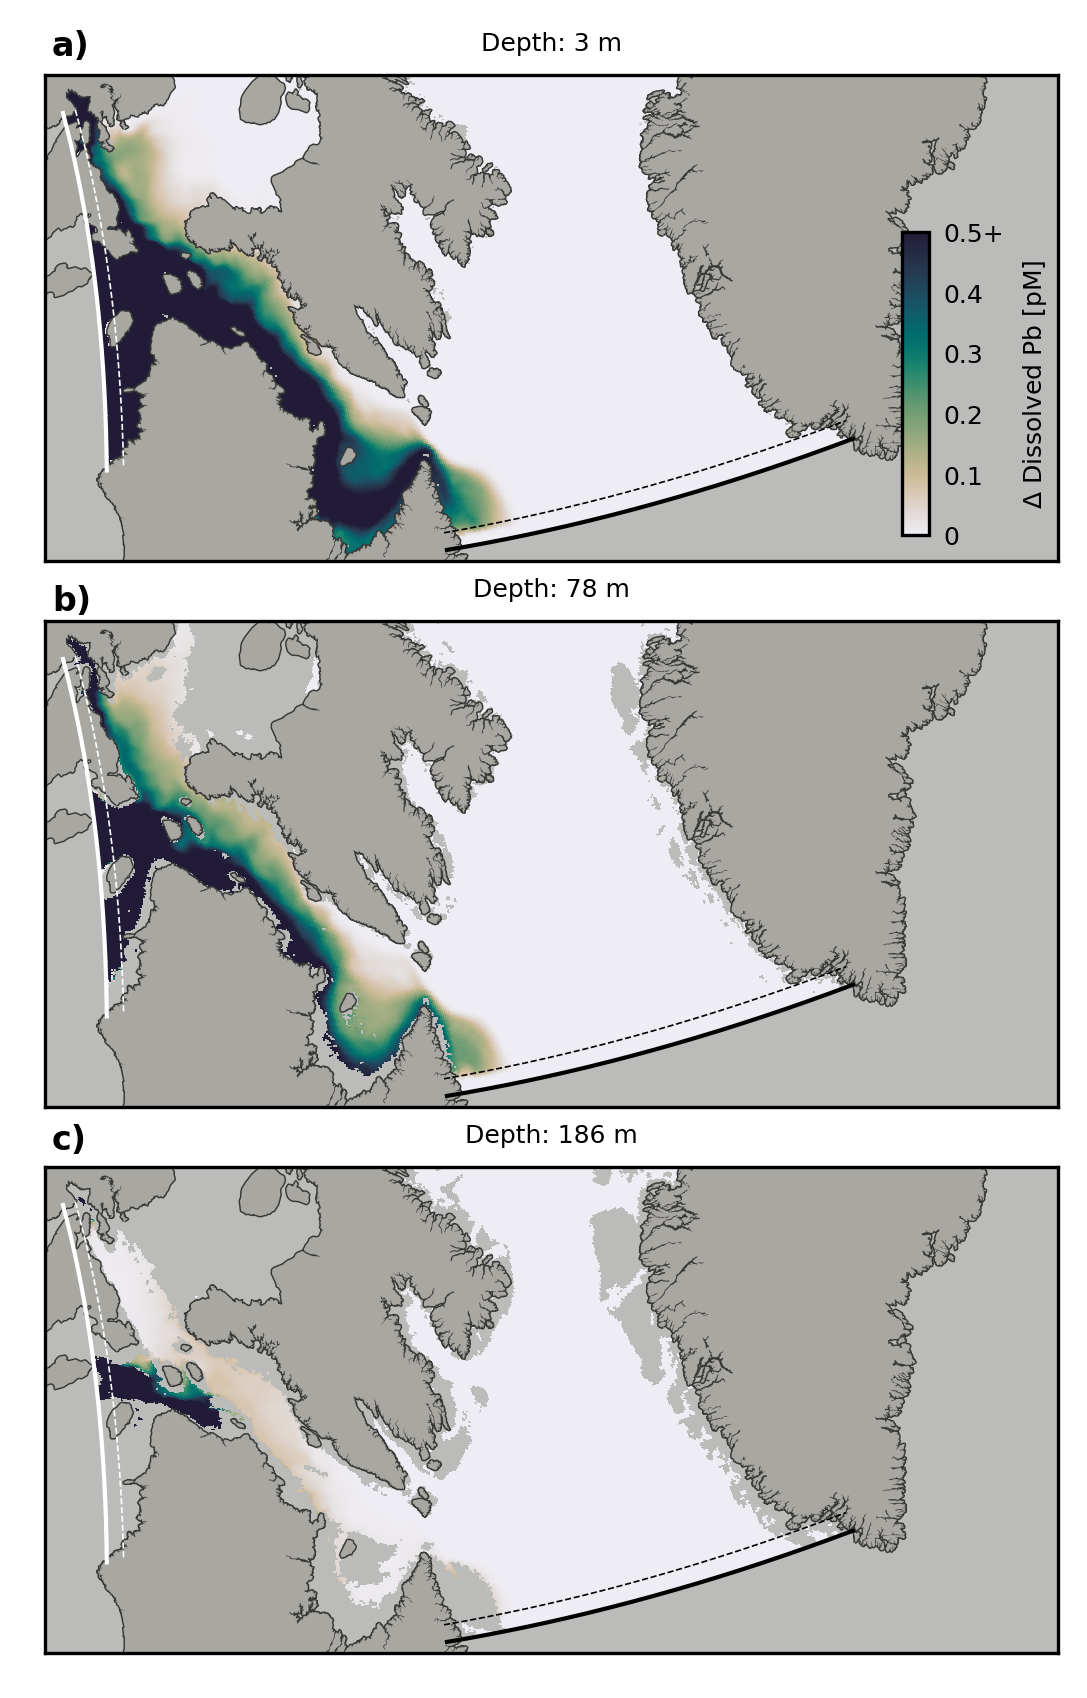

In [20]:
fig = plot_grid_layers(HB_diff, (2,20,25), vmin=0, vmax=0.5)

fig.text(0.13, 0.985, 'a)', fontsize=8, weight='bold');
fig.text(0.13, 0.655, 'b)', fontsize=8, weight='bold');
fig.text(0.13, 0.335, 'c)', fontsize=8, weight='bold');

In [21]:
fig.savefig('/ocean/brogalla/GEOTRACES/figures/Pb/S8.jpg', dpi=300)